# Experimentacion

In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
import subprocess
import matplotlib.pyplot as plt
import glob, os
import math
import random
from subprocess import Popen, PIPE
from tqdm import tqdm

In [65]:
NS_PER_SECOND = 1000000000

def getTime(s, ns):
    if (s > 0 and ns < 0):
        ns += NS_PER_SECOND
        s=s-1
    elif (s < 0 and ns > 0):
        ns -= NS_PER_SECOND
        s=s+1

    ms = ns / 1000000
    ms += s * 1000
    return ms

In [66]:
executablePath = './../codigo/build/ContarPalabras'
os.chdir("./")
print(executablePath)

./../codigo/build/ContarPalabras


### Multithreading en maximo paralelo con distribucion uniforme

In [21]:
threads = [1,2,3,4,5,6,7,8,10,15,20,26]
columns = ['cantThreads', 'sec', 'ns', 'algorithm']

df = pd.DataFrame(columns = columns)
dataframes = []

for repeat in range(10):
    #create output file
    result = './results/uniforme.csv'
    outputFile = open(result, 'w+')
    outputFile.write("cantThreads,sec,ns,algorithm\n")
    
    args = "./data/uniforme.txt"
    
    for cantThreads in threads:
        command = executablePath + " %s %s %s" % (cantThreads, cantThreads, args)
        p = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
        p.wait()
        
        output=p.stdout.read().decode("utf-8")
        outputFile.write(output)
    
    outputFile.close()
    
    df = pd.read_csv(result, header=[0])
    dataframes.append(df)
    
dfExp = pd.concat(dataframes)
dfExp['time'] = dfExp.apply(lambda row : getTime(row['sec'],row['ns']), axis = 1)
dfExp = dfExp.drop(['sec', 'ns'], axis = 1)
result = dfExp.groupby(['cantThreads', 'algorithm']).agg({'time':['mean','std']}).reset_index()
print(result)

   cantThreads                algorithm        time           
                                               mean        std
0            1  cargarMultiplesArchivos  208.918053   2.711307
1            1           maximoParalelo    0.547482   0.025604
2            2  cargarMultiplesArchivos  211.497786   6.657803
3            2           maximoParalelo    0.335346   0.042721
4            3  cargarMultiplesArchivos  212.325412  13.198574
5            3           maximoParalelo    0.292312   0.010748
6            4  cargarMultiplesArchivos  209.108876   4.782903
7            4           maximoParalelo    0.290922   0.029952
8            5  cargarMultiplesArchivos  210.965369   8.777913
9            5           maximoParalelo    0.311504   0.020249
10           6  cargarMultiplesArchivos  213.748690  14.112363
11           6           maximoParalelo    0.334900   0.012810
12           7  cargarMultiplesArchivos  212.959242  12.564638
13           7           maximoParalelo    0.344830   0

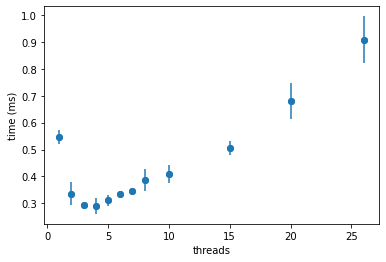

In [45]:
resultMaxParalelo = result
resultMaxParalelo = resultMaxParalelo.loc[resultMaxParalelo['algorithm'] == 'maximoParalelo']
time = resultMaxParalelo['time']['mean'].values.tolist()
std = resultMaxParalelo['time']['std'].values.tolist()
cantThreads = resultMaxParalelo['cantThreads'].values.tolist()

plt.scatter(cantThreads, time)
plt.errorbar(cantThreads,time, yerr = std, fmt="o")
plt.xlabel('threads')
plt.ylabel('time (ms)')
plt.show()

### Multithreading en cargar multiples archivos

In [ ]:
threads = [1,2,3,4,5,6,7,8,10,15,20,26]
columns = ['cantThreads', 'sec', 'ns', 'algorithm']

df = pd.DataFrame(columns = columns)
dataframes = []
datasetsDir="./data/incremental/"

for repeat in tqdm(range(10)):
    for dataset in os.listdir(datasetsDir):
        #create output file
        result = './results/uniformeMultiplesArchivos.csv'
        outputFile = open(result, 'w+')
        outputFile.write("cantThreads,sec,ns,algorithm\n")

        args = ""
        for file in os.listdir(datasetsDir):
            args += " " + datasetsDir + file

        #print (args)
        for cantThreads in threads:
            command = executablePath + " %s %s %s" % (cantThreads, cantThreads, args)
            p = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
            p.wait()

            output=p.stdout.read().decode("utf-8")
            outputFile.write(output)

        outputFile.close()

        df = pd.read_csv(result, header=[0])
        dataframes.append(df)
    
dfExp2 = pd.concat(dataframes)
print(dfExp2)

 80%|████████  | 8/10 [00:49<00:12,  6.10s/it]

In [ ]:
dfExp2['time'] = dfExp2.apply(lambda row : getTime(row['sec'],row['ns']), axis = 1)
dfExp2 = dfExp2.drop(['sec', 'ns'], axis = 1)
result2 = dfExp2.groupby(['cantThreads', 'algorithm']).agg({'time':['mean','std']}).reset_index()
print(result2)

In [ ]:
resultMultiArc = result2
resultMultiArc = resultMultiArc.loc[resultMultiArc['algorithm'] == 'cargarMultiplesArchivos']
time = resultMultiArc['time']['mean'].values.tolist()
std = resultMultiArc['time']['std'].values.tolist()
cantThreads = resultMultiArc['cantThreads'].values.tolist()

plt.scatter(cantThreads, time)
plt.errorbar(cantThreads,time, yerr = std, fmt="o")
plt.xlabel('threads')
plt.ylabel('time (ms)')
plt.show()

In [ ]:
for file in os.listdir(datasetsDir):
        args += " " + datasetsDir + file
        print(args)
        args = ""
